In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir("../../../DATA/Brain_subregion/")

In [3]:
# rna = sc.read_h5ad("rna.h5ad")
# atac = sc.read_h5ad("atac.h5ad")
# (rna.obs_names==atac.obs_names).all()

In [4]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main/")
import networkx as nx
import scanpy as sc
from switch import SWITCH, preprocess
from itertools import chain

In [5]:
# preprocess.get_gene_annotation(rna, 
#                     gtf="../Mouse_embryo/gencode.vM25.annotation.gtf.gz",
#                     gtf_by="gene_name",
#                     drop_na=True
# )

In [6]:
# rna.layers["counts"] = rna.X.copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3", layer="counts")

In [7]:
# split = atac.var_names.str.split(r"[:-]")
# atac.var["chrom"] = split.map(lambda x: x[0])
# atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
# atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# ## print(i.var)

In [8]:
# print(atac.shape[1])
# sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
# print(atac.shape[1])

In [9]:
# guidance = preprocess.rna_anchored_guidance_graph(rna, atac)
# len(atac.var[atac.var["highly_variable"]==True])

In [10]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")
# nx.write_graphml(guidance, "guidance.graphml.gz")
# guidance_hvf = guidance.subgraph(chain(
#    rna.var.query("highly_variable").index,
#    atac.var.query("highly_variable").index
# )).copy()
# nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [11]:
atac = sc.read_h5ad("atac-pp.h5ad")
rna = sc.read_h5ad("rna-pp.h5ad")
# # guidance = nx.read_graphml("guidance.graphml.gz")
guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

In [12]:
# sc.pp.filter_genes(atac, min_cells=10)
len(atac.var[atac.var["highly_variable"]==True])

12802

In [13]:
preprocess.config_data(
    rna, "NB", use_highly_variable=True,
    use_spatial=True,
    #use_rep = "X_pca",
    use_layer="counts",
    use_obs_names =False
)
preprocess.config_data(
    atac, "NB", use_highly_variable=True, 
    use_spatial=True,
    #use_rep = "X_lsi",
    use_obs_names=False
)

In [14]:
preprocess.Cal_Spatial_Net(rna, rad_cutoff=1, model="Radius")
preprocess.Cal_Spatial_Net(atac, rad_cutoff=1, model="Radius")
# preprocess.Cal_Spatial_Net(rna, k_cutoff=2, model="KNN")
# preprocess.Cal_Spatial_Net(atac, k_cutoff=2, model="KNN")

- INFO - Calculating 'spatial' graph.
The graph contains 9222 edges, 2373 spots.
3.8862 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 9222 edges, 2373 spots.
3.8862 neighbors per spot on average.


In [15]:
model = SWITCH(adatas={"rna": rna, "atac": atac}, vertices=sorted(guidance_hvf.nodes), 
               dropout=0.25,)

- INFO - Set random seed to 0
- DEBUG - Use raw feature for the 'rna' dataset.
- DEBUG - Set 1 GAT conv layer for 'rna' dataset.
- DEBUG - Use NB distribution for the 'rna' dataset.
- DEBUG - Use raw feature for the 'atac' dataset.
- DEBUG - Set 1 GAT conv layer for 'atac' dataset.
- DEBUG - Use NB distribution for the 'atac' dataset.
- DEBUG - Set 1 layers for the discriminator
- DEBUG - Use log normalize for the 'rna' dataset.
- DEBUG - Use log normalize for the 'atac' dataset.
- INFO - GPU available: True, used device: GPU 0


In [16]:
model.compile(lam_graph=0.4, lam_align=.75)

In [17]:
model.pretrain(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=3000, dsc_k=1)

- INFO - Prepare data for training.
- DEBUG - Set `dsc_k` = 1 for pretrain.
- DEBUG - Set `max_epochs` = 3000 for pretrain.
- INFO - Pretraining with full batch.
- INFO - Epoch 1 : dsc_loss=0.683, gen_loss=0.705
- INFO - Epoch 2 : dsc_loss=0.679, gen_loss=0.552
- INFO - Epoch 3 : dsc_loss=0.697, gen_loss=0.499
- INFO - Epoch 4 : dsc_loss=0.678, gen_loss=0.473
- INFO - Epoch 5 : dsc_loss=0.692, gen_loss=0.461
- INFO - Epoch 6 : dsc_loss=0.688, gen_loss=0.451
- INFO - Epoch 7 : dsc_loss=0.691, gen_loss=0.442
- INFO - Epoch 8 : dsc_loss=0.673, gen_loss=0.436
- INFO - Epoch 9 : dsc_loss=0.684, gen_loss=0.429
- INFO - Epoch 10 : dsc_loss=0.68, gen_loss=0.424
- INFO - Epoch 11 : dsc_loss=0.685, gen_loss=0.419
- INFO - Epoch 12 : dsc_loss=0.689, gen_loss=0.415
- INFO - Epoch 13 : dsc_loss=0.688, gen_loss=0.41
- INFO - Epoch 14 : dsc_loss=0.688, gen_loss=0.407
- INFO - Epoch 15 : dsc_loss=0.692, gen_loss=0.403
- INFO - Epoch 16 : dsc_loss=0.692, gen_loss=0.401
- INFO - Epoch 17 : dsc_loss=0.69

In [18]:
model.train(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=500, dsc_k=2)

- DEBUG - Set `dsc_k` = 2 for training.
- DEBUG - Set `max_epochs` = 500 for training.
- INFO - Training with full batch.
- INFO - Epoch 1 : dsc_loss=0.692, gen_loss=1.338, cycle_loss=0.383, align_loss=0.761
- INFO - Epoch 2 : dsc_loss=0.692, gen_loss=1.329, cycle_loss=0.381, align_loss=0.754
- INFO - Epoch 3 : dsc_loss=0.69, gen_loss=1.325, cycle_loss=0.38, align_loss=0.75
- INFO - Epoch 4 : dsc_loss=0.689, gen_loss=1.321, cycle_loss=0.379, align_loss=0.748
- INFO - Epoch 5 : dsc_loss=0.69, gen_loss=1.318, cycle_loss=0.379, align_loss=0.747
- INFO - Model training done.


In [19]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [20]:
combined = sc.concat([rna, atac], label="omics")

In [21]:
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined)

In [22]:
sc.tl.leiden(adata=combined, resolution=.2, key_added="leiden")
print(len(set(combined.obs["leiden"])))

6


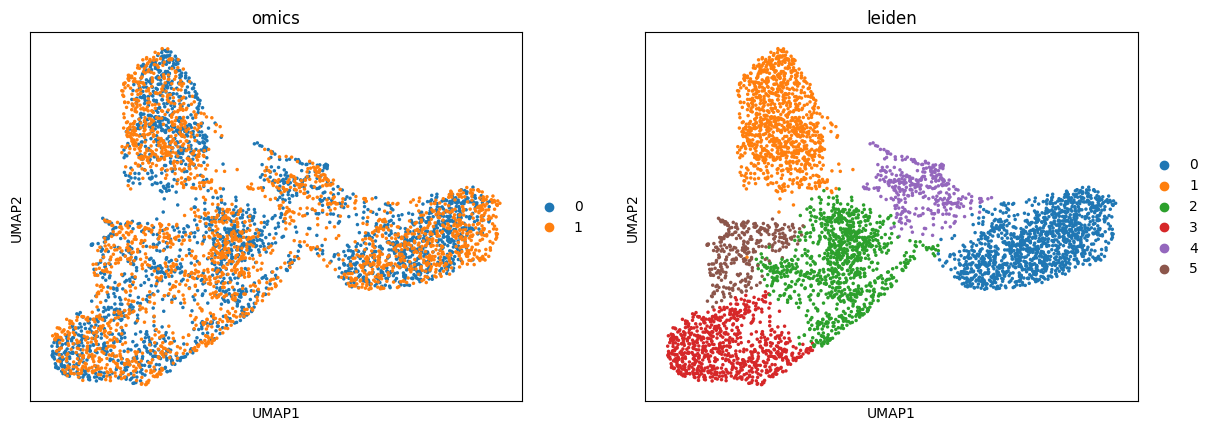

In [23]:
sc.pl.umap(combined, color=["omics","leiden"])

In [24]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

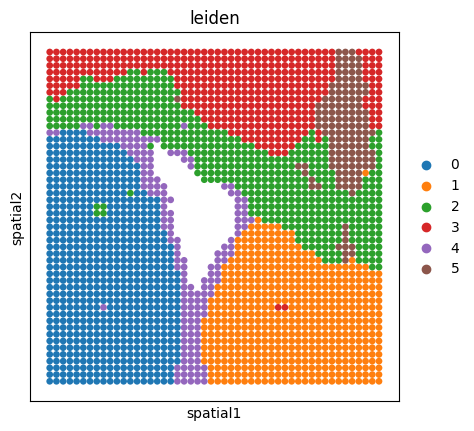

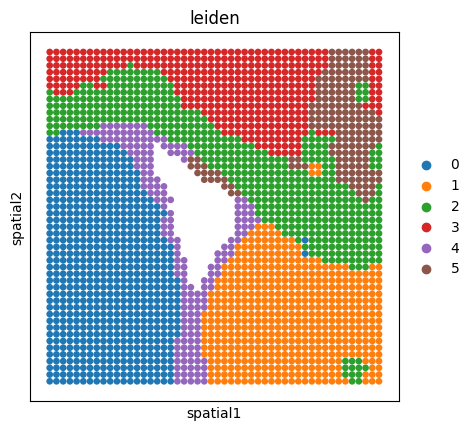

In [25]:
sc.pl.spatial(t_rna, color="leiden",spot_size=1)
sc.pl.spatial(t_atac, color="leiden",spot_size=1)

In [26]:
import scipy
def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
):
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    n1, _ = d.shape
    true_matching = np.arange(n1)
    mask = (d.T < d[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))
x=foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])
x

0.05611947444286928

In [27]:
embed = pd.DataFrame(combined.obsm["SWITCH"])
embed.to_csv("rep4/SWITCH_embed.csv")
umap = pd.DataFrame(combined.obsm["X_umap"])
umap.to_csv("rep4/SWITCH_umap.csv")
cluster = pd.DataFrame(combined.obs["leiden"])
cluster.to_csv("rep4/SWITCH_cluster.csv")